In [1]:
import numpy as np
x = np.array([1,2,3])
print(type(x))

<class 'numpy.ndarray'>


In [ ]:
"""
        software_set = {
                        'game': {'use_time': float, 'start_time': float, 'cpu_cost': float, 'gpu_cost': float},
                        'screen': {'use_time': float, 'start_time': float, 'cpu_cost': float, 'gpu_cost': float},
                        'wifi': {'use_time': float, 'start_time': float, 'cpu_cost': float, 'mod': str},
                        'gps': {'use_time': float, 'start_time': float, 'cpu_cost': float}
                    }
"""


In [2]:
# 荷载参数优化
import cv2

def screen_rgb(img: str, target_res: tuple):
    if isinstance(img, str):
        img = cv2.imread(img)
        if img is None:
            raise ValueError("无法加载图片，检查路径是否正确")
    resized_img = cv2.resize(img, target_res, interpolation=cv2.INTER_AREA)
    rgb_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
    kr = 0.006
    kg = 0.002
    kb = 0.006
    R = rgb_img[:, :, 0].astype(np.float32)
    G = rgb_img[:, :, 1].astype(np.float32)
    B = rgb_img[:, :, 2].astype(np.float32)
    pixel_weight = kr * R + kg * G + kb * B
    total_sum = np.sum(pixel_weight)
    return total_sum

screen_rgb('tim.jpg', (2622, 1206))

np.float32(3312402.2)

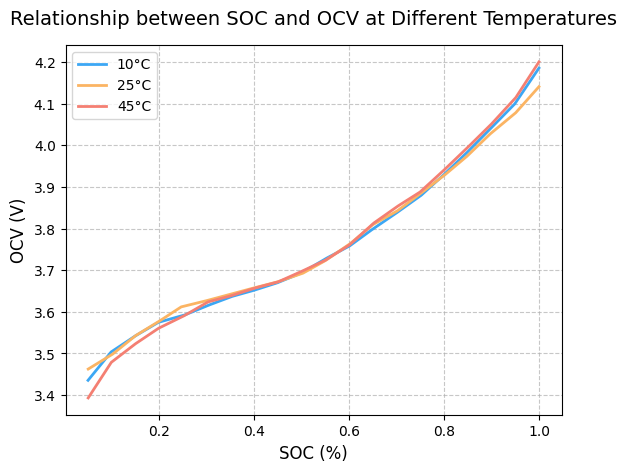

0.014161798548416751


In [ ]:
import matplotlib.pyplot as plt
import re

file = [r'soc _data\soc_ocv_10.txt', 
        r'soc _data\soc_ocv_25.txt', 
        r'soc _data\soc_ocv_45.txt']
colors = ["#3CA7F4", "#FBB463", "#F47F72"]  

soc_ocv_set = {}
for name, color in zip(file, colors):
    col1 = []
    col2 = []
    with open(name, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 2:
                col1.append(float(parts[0]))
                col2.append(float(parts[1]))
    temp = re.findall(r'_(\d+)\.txt$', name)[0]
    plt.plot(col1, col2, color=color, label=f'{temp}°C', linewidth=2)
    soc_ocv_set[f'{temp}'] = {'soc': col1, 'ocv': col2}
    

plt.title('Relationship between SOC and OCV at Different Temperatures', fontsize=14, pad=15)
plt.xlabel('SOC (%)', fontsize=12)
plt.ylabel('OCV (V)', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

print((soc_ocv_set['45']['ocv'][-1] - soc_ocv_set['25']['ocv'][-1]) / soc_ocv_set['45']['ocv'][-1])


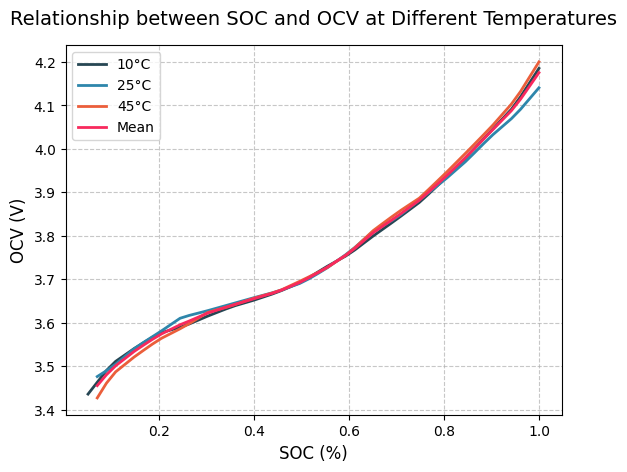

In [24]:
import matplotlib.pyplot as plt
import re
import numpy as np
from scipy.interpolate import interp1d  # 导入插值工具

# 文件路径（保持原路径）
file_list = [r'soc _data\soc_ocv_10.txt', 
             r'soc _data\soc_ocv_25.txt', 
             r'soc _data\soc_ocv_45.txt']
# 你图中的原版十六进制配色
colors = ['#264653', '#2E86AB', "#EB5E3B", "#5DEF84"]  
# 存储所有原始SOC数据，用于确定统一横坐标的范围
all_soc = []
# 存储每个文件的原始SOC和OCV
raw_data = []

# 第一步：读取所有文件的原始数据，收集所有SOC值
for name in file_list:
    soc = []
    ocv = []
    with open(name, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 2:
                s = float(parts[0])
                o = float(parts[1])
                soc.append(s)
                ocv.append(o)
                all_soc.append(s)  # 收集所有SOC到总列表
    raw_data.append((soc, ocv, name))

soc_min = np.min(all_soc)
soc_max = np.max(all_soc)
soc_uniform = np.linspace(soc_min, soc_max, 50)

# 第三步：插值+绘图（每条曲线映射到统一横坐标）
sum_ocv = 0
for (soc_raw, ocv_raw, name), color in zip(raw_data, colors):
    f = interp1d(soc_raw, ocv_raw, kind='linear', bounds_error=False, fill_value=np.nan)
    ocv_uniform = f(soc_uniform)
    sum_ocv += ocv_uniform
    temp = re.findall(r'_(\d+)\.txt$', name)[0]
    plt.plot(soc_uniform, ocv_uniform, color=color, label=f'{temp}°C', linewidth=2)

sum_ocv = sum_ocv / 3
plt.plot(soc_uniform, sum_ocv, color="#F8295D", label='Mean', linewidth=2)
# 图表样式设置（全英文）
plt.title('Relationship between SOC and OCV at Different Temperatures', fontsize=14, pad=15)
plt.xlabel('SOC (%)', fontsize=12)
plt.ylabel('OCV (V)', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)  # 虚线网格，提升可读性
plt.show()

name = r"soc_ocv_mean.txt"
with open(name, 'w', encoding='utf-8') as f:
        for x, y in zip(soc_uniform, sum_ocv):
            f.write(f"{x:.6f} {y:.6f}\n")

拟合后的相对内阻方程参数：
R0 = 1.09
Ea = 2740.79 J/mol
a = 0.000256
b = -0.048424
c = 26.60
d = 2.24

拟合优度 R² = 0.8815


<>:17: SyntaxWarning: invalid escape sequence '\s'
<>:17: SyntaxWarning: invalid escape sequence '\s'
C:\Users\lenovo\AppData\Local\Temp\ipykernel_44544\3898982954.py:17: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(file_path, sep="\s+", header=None, names=["SOC", "R"])


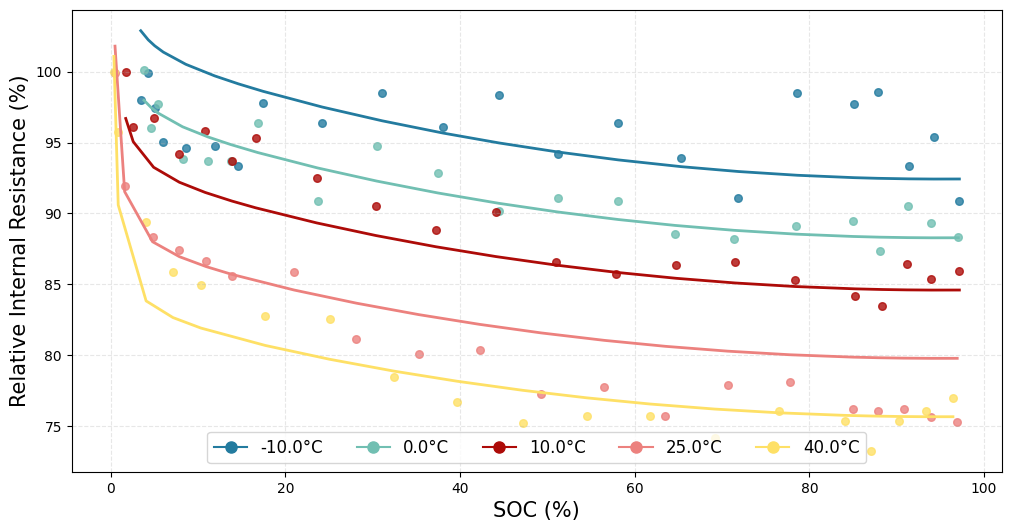

In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

file_temp_map = {
    "-10": "soc_r_-10.txt",
    "0": "soc_r_00.txt",
    "10": "soc_r_10.txt",
    "25": "soc_r_25.txt",
    "40": "soc_r_40.txt"
}

data_list = []
for temp_str, file_path in file_temp_map.items():
    T = float(temp_str) 
    df = pd.read_csv(file_path, sep="\s+", header=None, names=["SOC", "R"])
    df["T"] = T 
    data_list.append(df)
all_data = pd.concat(data_list, ignore_index=True)

SOC = all_data["SOC"].values  
T = all_data["T"].values      
R = all_data["R"].values 
X = np.vstack([SOC, T]).T    

R_g = 8.314  
epsilon = 0.01  

# def resistance_model(X, R0, Ea, a, b, c, d):
#     """
#     相对内阻模型: Rel_R = R0 * exp(Ea/(R_g*T_K)) * (a*SOC² + b*SOC + c + d/(SOC+epsilon))
#     X: 自变量矩阵 (n_samples, 2), 列0=SOC, 列1=T(℃)
#     Rel_R: 相对内阻(剩余原内阻的百分比，%)
#     参数: R0, Ea, a, b, c, d
#     """
#     SOC = X[:, 0]
#     T_celsius = X[:, 1]
#     T_K = T_celsius + 273.15
    
#     temp_term = np.exp(Ea / (R_g * T_K))
#     soc_term = a * SOC**2 + b * SOC + c + d / (SOC + epsilon)
#     R_pred = R0 * temp_term * soc_term
#     return R_pred

def resistance_model(X, R0, Ea, a, b, c, d):
    """
    相对内阻模型: Rel_R = R0 * ()
    X: 自变量矩阵 (n_samples, 2), 列0=SOC, 列1=T(℃)
    Rel_R: 相对内阻(剩余原内阻的百分比，%)
    参数: R0, Ea, a, b, c, d
    """
    SOC = X[:, 0]
    T_celsius = X[:, 1]
    T_K = T_celsius + 273.15  
    
    temp_term = np.exp(Ea / (R_g * T_K))
    soc_term = a * SOC**2 + b * SOC + c + d / (SOC + epsilon)
    R_pred = R0 * temp_term * soc_term
    return R_pred

initial_guess = [
    50,    
    1000,  
    -0.001,
    0.1,   
    50,    
    50     
]

bounds = (
    [0.1, 100, -0.01, -1, 10, 0],  
    [200, 5000, 0.01, 1, 150, 500]   
)
params, cov_matrix = curve_fit(
    f=resistance_model,
    xdata=X,
    ydata=R,  
    p0=initial_guess,
    bounds=bounds,
    maxfev=10000  
)

R0_fit, Ea_fit, a_fit, b_fit, c_fit, d_fit = params

Rel_R_pred = resistance_model(X, *params)

ss_res = np.sum((R - Rel_R_pred)**2) 
ss_tot = np.sum((R - np.mean(R))**2)  
r_squared = 1 - (ss_res / ss_tot)

print("拟合后的相对内阻方程参数：")
print(f"R0 = {R0_fit:.2f}")
print(f"Ea = {Ea_fit:.2f} J/mol")
print(f"a = {a_fit:.6f}")
print(f"b = {b_fit:.6f}")
print(f"c = {c_fit:.2f}")
print(f"d = {d_fit:.2f}")
print(f"\n拟合优度 R² = {r_squared:.4f}")


plt.figure(figsize=(12, 6))
temp_list = sorted([float(k) for k in file_temp_map.keys()])
colors = ['#237B9F', '#71BFB2', '#AD0B08', '#EC817E', '#FEE066']
markers = ['o', 'o', 'o', 'o', 'o'] 

for T_val, color, marker in zip(temp_list, colors, markers):
    mask = all_data["T"] == T_val
    plt.scatter(
        all_data.loc[mask, "SOC"], 
        all_data.loc[mask, "R"], 
        marker=marker,
        color=color,
        s=30, alpha=0.8
    )
    plt.plot(
        all_data.loc[mask, "SOC"],
        resistance_model(all_data.loc[mask, ["SOC", "T"]].values, *params),
        color=color,
        linewidth=2
    )

plt.xlabel("SOC (%)", fontsize=15)
plt.ylabel("Relative Internal Resistance (%)", fontsize=15)  
plt.grid(alpha=0.3, linestyle="--")  
plt.tick_params(labelsize=10)  

handles = []
labels = []
for T_val, color, marker in zip(temp_list, colors, markers):
    handle = plt.Line2D(
        [0], [0],
        marker=marker,
        color=color,
        linestyle="-",
        markersize=8,
        label=f"{T_val}°C"
    )
    handles.append(handle)
    labels.append(f"{T_val}°C")

plt.legend(
    handles=handles,
    labels=labels,
    loc="lower center",  
    ncol=5,  
    fontsize=12,
    frameon=True  
)

plt.show()

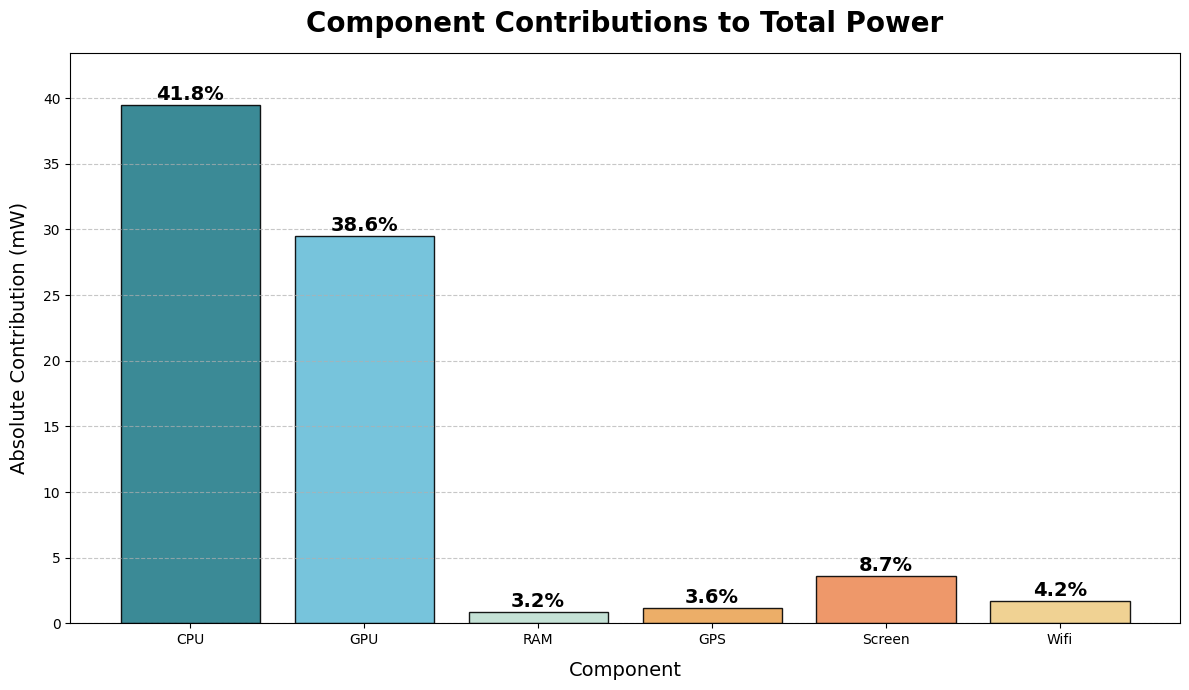

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# -------------------------- 1. 数据准备（与原图完全一致） --------------------------
components = ['CPU', 'GPU', 'RAM', 'GPS', 'Screen', 'Wifi']
power_contribution = [39.5, 29.5, 0.9, 1.2, 3.6, 1.7]
percentages = ['41.8%', '38.6%', '3.2%', '3.6%', '8.7%', '4.2%']

# -------------------------- 2. 自定义配置（可自由修改） --------------------------
# 图表大小：(宽度, 高度)
FIG_SIZE = (12, 7)
# 柱子颜色：可以是单一颜色，也可以为每个柱子单独设置颜色
BAR_COLOR = ['#257D8B', '#68BED9', '#BFDFD2', '#EAA558', '#ED8D5A', '#EFCE87']  # 青绿色，也可以用 ['#48a9a6', '#e4a7a0', ...] 这样的列表
# 标题字体大小
TITLE_FONT_SIZE = 20
# 坐标轴字体大小
AXIS_FONT_SIZE = 14
# 标注字体大小
LABEL_FONT_SIZE = 14

# -------------------------- 3. 绘图 --------------------------
plt.figure(figsize=FIG_SIZE)
bars = plt.bar(components, power_contribution, color=BAR_COLOR, edgecolor='black', alpha=0.9)

# 添加百分比标注
for bar, pct in zip(bars, percentages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.05, pct,
             ha='center', va='bottom', fontsize=LABEL_FONT_SIZE, fontweight='bold')

# 设置图表标题和坐标轴标签
plt.title('Component Contributions to Total Power', fontsize=TITLE_FONT_SIZE, fontweight='bold', pad=15)
plt.ylabel('Absolute Contribution (mW)', fontsize=AXIS_FONT_SIZE, labelpad=10)
plt.xlabel('Component', fontsize=AXIS_FONT_SIZE, labelpad=10)

# 调整Y轴范围，避免标注超出图表
plt.ylim(0, max(power_contribution) * 1.1)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
# 显示图表
plt.show()